In [1]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! pip install wandb weave

In [7]:
!pip install torch-fidelity


In [8]:
! wandb login

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: llodi22 (llodi22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(1, dim)
        self.fc2 = nn.Linear(dim, dim)

    def forward(self, t):
        t = t.view(-1, 1)
        h = F.relu(self.fc1(t))
        return F.relu(self.fc2(h))


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.emb_proj = nn.Linear(emb_dim, out_ch)
        self.gn1 = nn.GroupNorm(8, out_ch)
        self.gn2 = nn.GroupNorm(8, out_ch)

        if in_ch != out_ch:
            self.skip = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.skip = nn.Identity()

    def forward(self, x, emb):
        h = self.conv1(x)
        h = self.gn1(h)
        h = F.relu(h)

        emb_out = self.emb_proj(emb).view(emb.shape[0], -1, 1, 1)
        h = h + emb_out

        h = self.conv2(h)
        h = self.gn2(h)
        return F.relu(h + self.skip(x))


class UNetScore(nn.Module):
    def __init__(self, base_ch=64):
        super().__init__()
        self.time_emb = TimeEmbedding(128)

        self.down1 = ResBlock(3, base_ch, 128)
        self.down2 = ResBlock(base_ch, base_ch*2, 128)
        self.down3 = ResBlock(base_ch*2, base_ch*4, 128)

        self.mid = ResBlock(base_ch*4, base_ch*4, 128)

        self.up3 = ResBlock(base_ch*8, base_ch*2, 128)
        self.up2 = ResBlock(base_ch*4, base_ch, 128)
        self.up1 = ResBlock(base_ch*2, base_ch, 128)

        self.out = nn.Conv2d(base_ch, 3, 3, padding=1)

        self.pool = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, sigma):
        emb = self.time_emb(torch.log(sigma))


        d1 = self.down1(x, emb)
        d2 = self.down2(self.pool(d1), emb)
        d3 = self.down3(self.pool(d2), emb)

        mid = self.mid(self.pool(d3), emb)

        u3 = self.up(mid)
        u3 = self.up3(torch.cat([u3, d3], dim=1), emb)

        u2 = self.up(u3)
        u2 = self.up2(torch.cat([u2, d2], dim=1), emb)

        u1 = self.up(u2)
        u1 = self.up1(torch.cat([u1, d1], dim=1), emb)

        return self.out(u1)


In [10]:
import numpy as np

def geometric_schedule(sigma_min, sigma_max, L):
    return np.exp(np.linspace(np.log(sigma_max), np.log(sigma_min), L))

def linear_schedule(sigma_min, sigma_max, L):
    return np.linspace(sigma_max, sigma_min, L)


In [11]:
def dsm_loss(model, x, sigmas):
    batch_size = x.size(0)

    # sample random noise level
    idx = torch.randint(0, len(sigmas), (batch_size,), device=x.device)
    sigma = sigmas[idx].view(batch_size, 1, 1, 1)

    noise = torch.randn_like(x)
    x_noisy = x + sigma * noise

    score = model(x_noisy, sigma.squeeze())

    target = -noise / sigma
    # σ² weighting (CRITICAL)
    loss = ((score - target) ** 2 * sigma**2).mean()
    return loss


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNetScore().to(device)

sigma_min = 0.01
sigma_max = 50.0
L = 10

sigmas_geom = torch.tensor(
    geometric_schedule(sigma_min, sigma_max, L),
    dtype=torch.float32, device=device
)


In [13]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

ema_model = UNetScore().to(device)
ema_model.load_state_dict(model.state_dict())

def update_ema(model, ema_model, decay=0.999):
    with torch.no_grad():
        for p, ema_p in zip(model.parameters(), ema_model.parameters()):
            ema_p.data = decay * ema_p.data + (1 - decay) * p.data


In [15]:
import wandb

run = wandb.init(
    entity="llodi22-free-university-of-tbilisi-",
    project="CIFAR-10",
    config={
        "architecture": "NCSN-UNet",
        "dataset": "CIFAR-10",
        "epochs": 50,
        "noise_schedule": "geometric",
        "L": L,
        "sigma_min": sigma_min,
        "sigma_max": sigma_max,
    }
)


wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: llodi22 (llodi22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [16]:
import os

checkpoint_dir = "/content/drive/MyDrive/Monet"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(epoch):
    torch.save({
        "model": model.state_dict(),
        "ema_model": ema_model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch
    }, f"{checkpoint_dir}/ncsn_epoch_{epoch}.pth")
    print("Checkpoint directory:", checkpoint_dir)

def load_checkpoint(path):
    ckpt = torch.load(path)
    model.load_state_dict(ckpt["model"])
    ema_model.load_state_dict(ckpt["ema_model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    return ckpt["epoch"]




In [17]:
epochs = 50
start_epoch = 1

for epoch in range(start_epoch, epochs+1):
    model.train()
    total_loss = 0

    for x, _ in loader:
        x = x.to(device)

        loss = dsm_loss(model, x, sigmas_geom)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_ema(model, ema_model)

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)

    print(f"Epoch {epoch} Loss {avg_loss:.4f}")

    wandb.log({
        "epoch": epoch,
        "train_loss": avg_loss
    })

    save_checkpoint(epoch)


Epoch 1 Loss 97.5927
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 2 Loss 1.0753
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 3 Loss 1.0234
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 4 Loss 1.0050
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 5 Loss 1.0007
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 6 Loss 0.9995
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 7 Loss 0.9230
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 8 Loss 0.7258
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 9 Loss 0.6583
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 10 Loss 0.6177
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 11 Loss 0.5837
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 12 Loss 0.5546
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 13 Loss 0.5227
Checkpoint directory: /content/drive/MyDrive/Monet
Epoch 14 Loss 0.5012
Checkpoint directory: /content/drive/MyDrive/Monet


In [18]:
def snr_step_size(sigma, sigma_min, base_eps=1e-5):
    return base_eps * (sigma / sigma_min) ** 2


In [30]:
@torch.no_grad()
def annealed_langevin(model, sigmas, steps_per_level=50, snr=False):
    model.eval()
    x = torch.randn(64, 3, 32, 32).to(device)

    sigma_min = sigmas[-1]

    for sigma in sigmas:
        sigma_tensor = torch.full((x.size(0),), sigma, device=device)

        for _ in range(steps_per_level):
            score = model(x, sigma_tensor)

            if snr:
                alpha = snr_step_size(sigma, sigma_min)
            else:
                alpha = 1e-5 * (sigma / sigma_min) ** 2

            noise = torch.randn_like(x)
            x = x + alpha * score + torch.sqrt(torch.tensor(2*alpha)) * noise

    return x



/tmp/ipython-input-1262666351.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = x + alpha * score + torch.sqrt(torch.tensor(2*alpha)) * noise


(np.float64(-0.5), np.float64(137.5), np.float64(69.5), np.float64(-0.5))

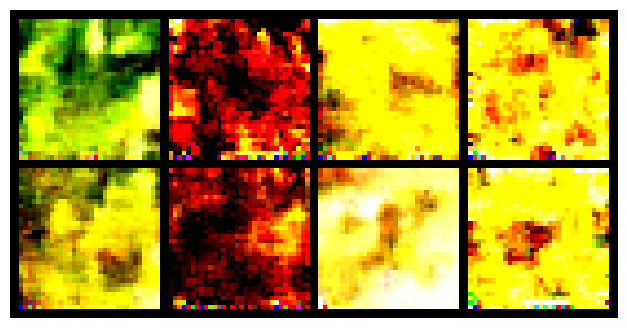

In [31]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

ema_model.eval()

# სემპლების გენერაცია
samples = annealed_langevin(ema_model, sigmas_geom)

# ნორმალიზაცია [-1,1] → [0,1]
samples = (samples.clamp(-1,1) + 1) / 2

# 8 სურათის grid (4 სვეტი × 2 რიგი)
grid = vutils.make_grid(samples[:8], nrow=4)

plt.figure(figsize=(8,4))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis('off')


/tmp/ipython-input-1262666351.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = x + alpha * score + torch.sqrt(torch.tensor(2*alpha)) * noise


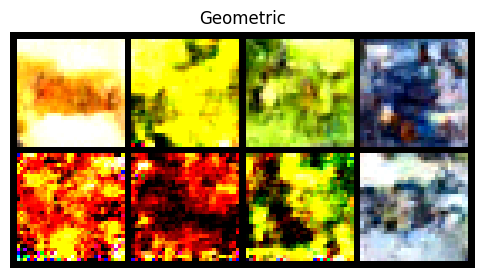

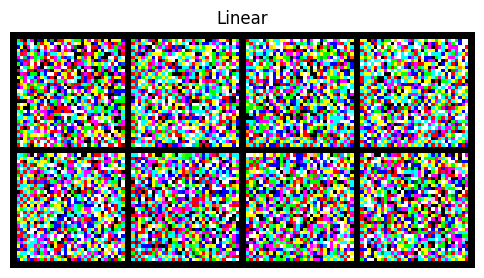

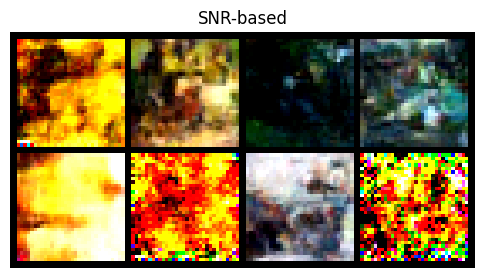

In [34]:
samples_geom = annealed_langevin(ema_model, sigmas_geom, snr=False)

sigmas_linear = torch.tensor(
    linear_schedule(sigma_min, sigma_max, L),
    dtype=torch.float32, device=device
)
samples_linear = annealed_langevin(ema_model, sigmas_linear, snr=False)

samples_snr = annealed_langevin(ema_model, sigmas_geom, snr=True)

def show_grid(samples, title):
    import matplotlib.pyplot as plt
    import torchvision.utils as vutils

    samples = (samples.clamp(-1,1) + 1) / 2
    grid = vutils.make_grid(samples[:8], nrow=4)

    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.imshow(grid.permute(1,2,0).cpu())
    plt.axis('off')

show_grid(samples_geom, "Geometric")
show_grid(samples_linear, "Linear")
show_grid(samples_snr, "SNR-based")



In [35]:
wandb.log({
    "samples_geometric": [wandb.Image(samples_geom[i]) for i in range(8)],
    "samples_linear": [wandb.Image(samples_linear[i]) for i in range(8)],
    "samples_snr": [wandb.Image(samples_snr[i]) for i in range(8)],
})


wandb: WARNING Data passed to `wandb.Image` should consist of values in the range [0, 255], image data will be normalized to this range, but behavior will be removed in a future version of wandb.


In [36]:
from torch_fidelity import calculate_metrics
import torchvision.utils as vutils
import os


In [37]:
sample_dir = "/content/generated_samples"
os.makedirs(sample_dir, exist_ok=True)

num_samples = 10000
batch_size = 100
count = 0

while count < num_samples:
    samples = annealed_langevin(ema_model, sigmas_geom, steps_per_level=50)

    # de-normalize from [-1,1] → [0,1]
    samples = (samples.clamp(-1,1) + 1) / 2

    for i in range(samples.size(0)):
        vutils.save_image(samples[i], f"{sample_dir}/{count+i}.png")

    count += samples.size(0)
    print(f"Generated {count}/{num_samples}")


/tmp/ipython-input-1262666351.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = x + alpha * score + torch.sqrt(torch.tensor(2*alpha)) * noise


Generated 64/10000
Generated 128/10000
Generated 192/10000
Generated 256/10000
Generated 320/10000
Generated 384/10000
Generated 448/10000
Generated 512/10000
Generated 576/10000
Generated 640/10000
Generated 704/10000
Generated 768/10000
Generated 832/10000
Generated 896/10000
Generated 960/10000
Generated 1024/10000
Generated 1088/10000
Generated 1152/10000
Generated 1216/10000
Generated 1280/10000
Generated 1344/10000
Generated 1408/10000
Generated 1472/10000
Generated 1536/10000
Generated 1600/10000
Generated 1664/10000
Generated 1728/10000
Generated 1792/10000
Generated 1856/10000
Generated 1920/10000
Generated 1984/10000
Generated 2048/10000
Generated 2112/10000
Generated 2176/10000
Generated 2240/10000
Generated 2304/10000
Generated 2368/10000
Generated 2432/10000
Generated 2496/10000
Generated 2560/10000
Generated 2624/10000
Generated 2688/10000
Generated 2752/10000
Generated 2816/10000
Generated 2880/10000
Generated 2944/10000
Generated 3008/10000
Generated 3072/10000
Generate

In [38]:
metrics = calculate_metrics(
    input1=sample_dir,
    input2='cifar10-train',
    fid=True,
    cuda=True
)

fid_value = metrics['frechet_inception_distance']
print("FID:", fid_value)

wandb.log({"FID_geometric": fid_value})


Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 420MB/s]
Extracting statistics from input 1
Looking for samples non-recursivelty in "/content/generated_samples" with extensions png,jpg,jpeg
Found 10048 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py

FID: 231.21383300112825


Frechet Inception Distance: 231.21383300112825


In [40]:
import torchvision.utils as vutils

sample_dir_linear = "/content/generated_linear"
os.makedirs(sample_dir_linear, exist_ok=True)

for i in range(10000 // 64):
    samples = annealed_langevin(ema_model, sigmas_linear, snr=False)
    samples = (samples.clamp(-1,1) + 1) / 2

    for j in range(samples.size(0)):
        vutils.save_image(samples[j], f"{sample_dir_linear}/{i*64+j}.png")


/tmp/ipython-input-1262666351.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = x + alpha * score + torch.sqrt(torch.tensor(2*alpha)) * noise


In [41]:
sample_dir_snr = "/content/generated_snr"
os.makedirs(sample_dir_snr, exist_ok=True)
count = 0
num_samples = 10000
for i in range(10000 // 64):
    samples = annealed_langevin(ema_model, sigmas_geom, snr=True)
    samples = (samples.clamp(-1,1) + 1) / 2

    for j in range(samples.size(0)):
        vutils.save_image(samples[j], f"{sample_dir_snr}/{i*64+j}.png")
    count+=64
    print(f"Generated {count}/{num_samples}")

/tmp/ipython-input-1262666351.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = x + alpha * score + torch.sqrt(torch.tensor(2*alpha)) * noise


Generated 64/10000
Generated 128/10000
Generated 192/10000
Generated 256/10000
Generated 320/10000
Generated 384/10000
Generated 448/10000
Generated 512/10000
Generated 576/10000
Generated 640/10000
Generated 704/10000
Generated 768/10000
Generated 832/10000
Generated 896/10000
Generated 960/10000
Generated 1024/10000
Generated 1088/10000
Generated 1152/10000
Generated 1216/10000
Generated 1280/10000
Generated 1344/10000
Generated 1408/10000
Generated 1472/10000
Generated 1536/10000
Generated 1600/10000
Generated 1664/10000
Generated 1728/10000
Generated 1792/10000
Generated 1856/10000
Generated 1920/10000
Generated 1984/10000
Generated 2048/10000
Generated 2112/10000
Generated 2176/10000
Generated 2240/10000
Generated 2304/10000
Generated 2368/10000
Generated 2432/10000
Generated 2496/10000
Generated 2560/10000
Generated 2624/10000
Generated 2688/10000
Generated 2752/10000
Generated 2816/10000
Generated 2880/10000
Generated 2944/10000
Generated 3008/10000
Generated 3072/10000
Generate

In [43]:
!rm -rf /root/.cache/torch/fidelity_cache


In [44]:
# Linear schedule
sample_dir_linear = "/content/generated_linear"
os.makedirs(sample_dir_linear, exist_ok=True)

# generate + save same way using sigmas_linear
# then:

metrics_linear = calculate_metrics(
    input1=sample_dir_linear,
    input2='cifar10-train',
    fid=True,
    cuda=True
)

wandb.log({"FID_linear": metrics_linear['frechet_inception_distance']})




Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/content/generated_linear" with extensions png,jpg,jpeg
Found 9984 samples
Processing samples
Extracting statistics from input 2
Processing samples
Caching /root/.cache/torch/fidelity_cache/cifar10-train-inception-v3-compat-features-2048.pt
Caching /root/.cache/torch/fidelity_cache/cifar10-train-inception-v3-compat-stat-fid-2048.pt
Frechet Inception Distance: 477.4682000461447
Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/content/generated_snr" with extensions png,jpg,jpeg
Found 9984 samples
Processing samples
Extracting statistics from input 2
Loading cached /root/.cache/torch/fidelity_cache/cifar10-train-inception-v3-compat-stat-fid-2048.pt


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray._reconstruct])` or the `torch.serialization.safe_globals([numpy._core.multiarray._reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [45]:
!rm -rf /root/.cache/torch/fidelity_cache

In [46]:
# SNR-based
sample_dir_snr = "/content/generated_snr"
os.makedirs(sample_dir_snr, exist_ok=True)

# generate + save
metrics_snr = calculate_metrics(
    input1=sample_dir_snr,
    input2='cifar10-train',
    fid=True,
    cuda=True
)

wandb.log({"FID_snr": metrics_snr['frechet_inception_distance']})


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/content/generated_snr" with extensions png,jpg,jpeg
Found 9984 samples
Processing samples
Extracting statistics from input 2
Processing samples
Caching /root/.cache/torch/fidelity_cache/cifar10-train-inception-v3-compat-features-2048.pt
Caching /root/.cache/torch/fidelity_cache/cifar10-train-inception-v3-compat-stat-fid-2048.pt
Frechet Inception Distance: 230.74782510170178
